# Исследование данных сервиса аренды самокатов

**Цели и описание проекта:**

Есть данные одного популярного сервиса аренды самокатов GoFast. Данные даны в трех датасетах и содержат следующую информацию:
- ID пользователя 
- Имя
- Возраст
- Город
- Тип подписки
- Данные о длительности, дальности и дате поездки
- Виды подписок и тарифы

**Задача проекта:**

Проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, поэтому нужно выяснить несколько важных моментов:

- Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
- Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

Сначала мы загрузим все данные, сделаем их предобработку. Потом проведем исследовательский анализ и изучим их особенности. В конце проверим гипотезы и сделаем выводы.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import factorial
from math import sqrt
from scipy.stats import binom, norm

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

####  Загрузка данных

##### Загрузка файла с данными о пользователях сервиса

In [2]:
try:
    users = pd.read_csv('/datasets/users_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


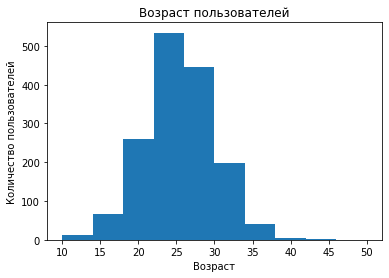

In [4]:
# Посмотрим как распределены данные в столбце с возрастом клиентов
plt.hist(users['age'], bins=10, range=(10,50))
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

##### Загрузка файла с данными о поездках

In [5]:
try:
    rides = pd.read_csv('/datasets/rides_go.csv')
except:
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

rides.head()

,user_id,distance,duration,date
0,1,"4,409.92",25.60,2021-01-01
1,1,"2,617.59",15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,"2,694.78",18.51,2021-08-11
4,1,"4,028.69",26.27,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


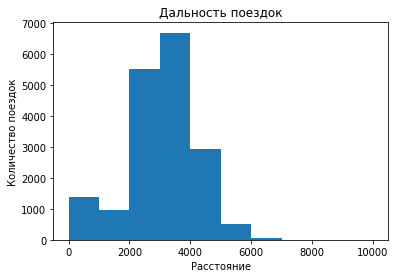

In [7]:
# Посмотрим как распределены данные в столбце с дальностью поездок
plt.hist(rides['distance'], bins=10, range=(0,10000))
plt.title('Дальность поездок')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

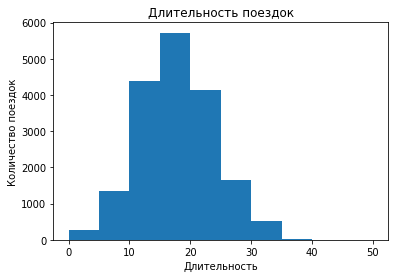

In [8]:
# Посмотрим как распределены данные в столбце с длительнотью поездок
plt.hist(rides['duration'], bins=10, range=(0,50))
plt.title('Длительность поездок')
plt.xlabel('Длительность')
plt.ylabel('Количество поездок')
plt.show()

##### Загрузка файла с информацией о подписках и тарифах

In [9]:
try:
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод:**
Первый датасет содержит данные о чуть более 1500 пользователях сервиса аренды. Во втором - более 18 тыс. строк о совершенных этими пользователями поездках. В третьем файле информация о подписках и тарифах, он содержит всего две строки. Пропуски в данных не обнаружены и практически все типы данных соответствуют ожидаемым. Исключением является информация о датах поездок, во втором датасете, тип которой необходимо будет преобразовать. Данные в столбцах с информацией о возрасте клиентов, длительностью  и дальностью поездок имеют распределение, близкое к нормальному. Аномальных значений и выбросов немного. Вместе с тем, есть много близких к нулевым значений в данных о дальности поездки, можно предположить, что это связано с отказом по какой-то причине от поездки сразу после активации самоката (как вариант - обнаружена неисправность)

#### Предобработка данных

##### Изменение типов данных

In [11]:
# Приведем тип данных столбца date к формату даты
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [12]:
# Создадим новый столбец с номером месяца
rides['month'] = rides['date'].dt.month

In [13]:
rides.head()

,user_id,distance,duration,date,month
0,1,"4,409.92",25.60,2021-01-01,1
1,1,"2,617.59",15.82,2021-01-18,1
2,1,754.16,6.23,2021-04-20,4
3,1,"2,694.78",18.51,2021-08-11,8
4,1,"4,028.69",26.27,2021-08-28,8


In [14]:
# Посмотрим за какой период есть данные о поездках
print('Начало периода:', rides['date'].min())
print('Конец периода:', rides['date'].max())

Начало периода: 2021-01-01 00:00:00
Конец периода: 2021-12-30 00:00:00


##### Проверка на дубликаты

In [15]:
# Проверим датасеты на наличие явных дубликатов
users.duplicated().sum()

31

In [16]:
rides.duplicated().sum()

0

In [17]:
# Удалим явные дубликаты 
users = users.drop_duplicates().reset_index(drop=True)

In [18]:
#Проверим наличие неявных дубликатов
users['user_id'].duplicated().sum()

0

**Вывод:**
В процессе предобработки данных мы привели тип данных в столбце **date** к формату даты. Также датасеты были проверены на наличие явных дубликатов, в результате чего такие были обнаружены и удалены в одном из них. Дубликатов с одинаковым ID найдено не было. Дубликаты в остальных столбцах искать не имеет смысла, поскольку имя, возраст и город проживания могут быть у разных людей одинаковыми.

Данные о поездках имеются за период с 01.01.2021 по 30.12.2021

#### Исследовательский анализ данных

##### Частота встречаемости городов

In [19]:
# Переименуем столбцы для дальнейшей наглядности
users = users.rename(columns={
    'city':'Город',
    'user_id':'Пользователи',
    'age':'Возраст',
    'subscription_type':'Подписка',
    'name':'Имя'
})

rides = rides.rename(columns={
    'distance':'Расстояние',
    'duration':'Продолжительность',
    'user_id':'Пользователи',
    'date':'Дата',
    'month':'Месяц'
})

subscriptions = subscriptions.rename(columns={
    'subscription_type':'Подписка',
    'minute_price':'Стоимость минуты',
    'start_ride_price':'Стоимость старта',
    'subscription_fee':'Ежемесячный платеж'
})

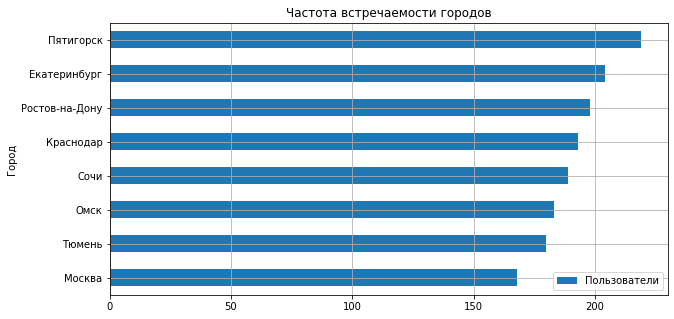

,Пользователи
Город,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [20]:
#Создадим таблицу с распределением пользователей по городам
city_pivot = users.pivot_table(
    index=['Город'],
    values=['Пользователи'],
    aggfunc='count')\
.sort_values(by='Пользователи', ascending=False)

# Построим барчарт по частоте встречаемости городов
city_pivot.sort_values(by='Пользователи').plot(
    kind='barh',
    figsize = (10, 5),
    grid = True,
    title='Частота встречаемости городов',
    ylabel='Количество пользователей'
)
plt.show()

city_pivot

Больше всего пользователей находятся в г.Пятигорске, меньше - в Москве

#####  Cоотношение пользователей с подпиской и без подписки

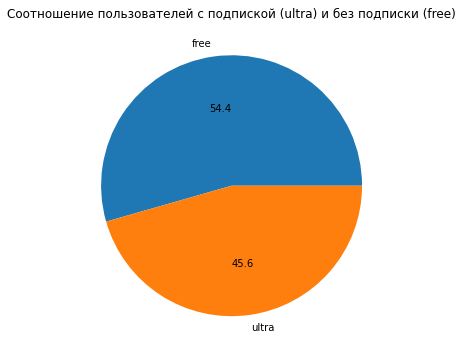

In [21]:
# Для визуализации соотношения построим круговую диаграмму
users['Подписка'].value_counts()\
        .plot(y='count',
              kind='pie',
              autopct='%.1f',
              figsize=(6, 6),
              title='Cоотношение пользователей с подпиской (ultra) и без подписки (free)',
              ylabel=''
            );

Пользователей с подпиской на 8,8% иеньше, чем пользователей без подписки

##### Возраст пользователей

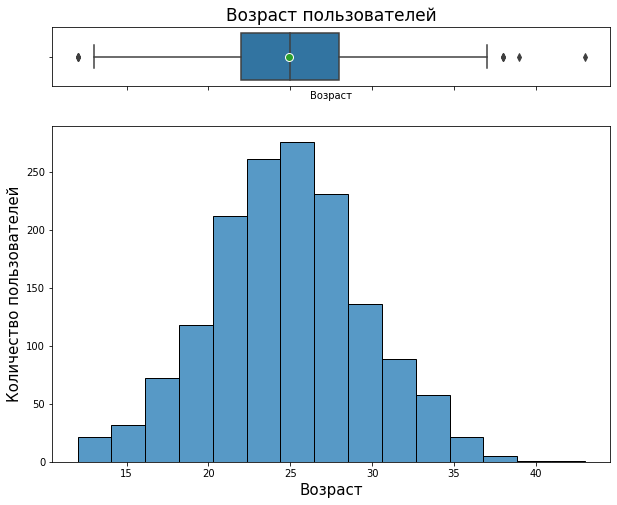

Статистические данные по возрасту: 

count   1,534.00
mean       24.90
std         4.57
min        12.00
25%        22.00
50%        25.00
75%        28.00
max        43.00
Name: Возраст, dtype: float64


In [22]:
#Построим гистограмму и боксплот для возраста пользователей
# создадим два подграфика
f, (ax_box, ax_hist) = \
plt.subplots(nrows = 2, # из двух строк
             ncols = 1, # и одного столбца
             sharex = True, # оставим только нижние подписи к оси Х
             gridspec_kw = {'height_ratios': (.15, .85)}, # зададим разную высоту строк
             figsize = (10,8)) # зададим размер графика
# в первом подграфике построим boxplot
sns.boxplot(x = users['Возраст'],
            ax = ax_box,
            showmeans=True, # покажем среднее значение
            meanprops={"marker": "o",
                       "markeredgecolor": "white",
                       "markersize": "8"})
# во втором гистограмму
sns.histplot(data = users['Возраст'], bins = 15, ax = ax_hist)

# зададим заголовок и подписи к осям
ax_box.set_title('Возраст пользователей', fontsize = 17)
ax_hist.set_xlabel('Возраст', fontsize = 15)
ax_hist.set_ylabel('Количество пользователей', fontsize = 15)

plt.show()

#Покажем статистические данные
print('Статистические данные по возрасту:', '\n')
print(users['Возраст'].describe())

Пользователи от 22 до 28 лет составляют 50% от общего количества. Среднее значение возраста и медиана практически одинаковы и равны 25 годам. Есть один выброс по  нижней границе боксплота и три выброса сверху.

##### Расстояние, которое пользователи преодолевают за одну поездку

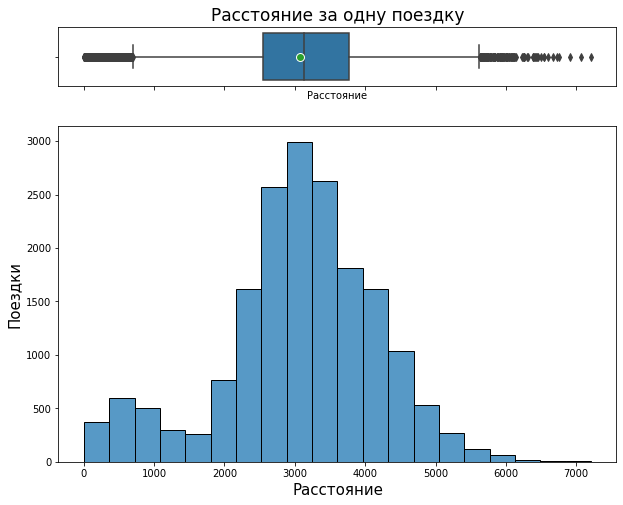

Статистические данные по расстоянию одной поездки: 

count   18,068.00
mean     3,070.66
std      1,116.83
min          0.86
25%      2,543.23
50%      3,133.61
75%      3,776.22
max      7,211.01
Name: Расстояние, dtype: float64


In [23]:
#Построим гистограмму и боксплот для расстояния поездок
# создадим два подграфика
f, (ax_box, ax_hist) = \
plt.subplots(nrows = 2, 
             ncols = 1, 
             sharex = True, 
             gridspec_kw = {'height_ratios': (.15, .85)},
             figsize = (10,8)) 
# в первом подграфике построим boxplot
sns.boxplot(x = rides['Расстояние'],
            ax = ax_box,
            showmeans=True, # покажем среднее значение
            meanprops={"marker": "o",
                       "markeredgecolor": "white",
                       "markersize": "8"})
# во втором гистограмму
sns.histplot(data = rides['Расстояние'], bins = 20, ax = ax_hist)

# зададим заголовок и подписи к осям
ax_box.set_title('Расстояние за одну поездку', fontsize = 17)
ax_hist.set_xlabel('Расстояние', fontsize = 15)
ax_hist.set_ylabel('Поездки', fontsize = 15)

plt.show()

#Покажем статистические данные
print('Статистические данные по расстоянию одной поездки:', '\n')
print(rides['Расстояние'].describe())

In [24]:
# Посмотрим какое количество поездок оказалось за усами боксплота
q1 = rides['Расстояние'].quantile(0.25)
q3 = rides['Расстояние'].quantile(0.75)
iqr = q3-q1
print('Общее количество поездок:', rides['Расстояние'].count())
print('Количество поездок за нижней границей:',
      rides.query('Расстояние < @q1-@iqr*1.5')['Расстояние'].count())
print('Количество поездок за верхней границей:',
      rides.query('Расстояние > @q3+@iqr*1.5')['Расстояние'].count())

Общее количество поездок: 18068
Количество поездок за нижней границей: 910
Количество поездок за верхней границей: 126


Расстоянние, которое в среднем проезжают пользователи за одну поездку, равняется 3070 метрам. Это значение близко к медиане, которая равна 3133 метра. Основная часть всех поездок укладывается в диапазон расстояний от 2,5 до 3,8 км. На графике размаха видно, что существуют выбросы по верхней и нижней границе усов. Так около 5% поездок находятся за нижним пределом и менее 1% - за верхним. Также наблюдается небольшой "провал" в поездках на 1500 м. Возможно, стоит более внимательно изучить очень короткие поездки, в каких городах их больше или, к примеру, посмотреть на зависимость их от подписки. Тогда можно будет предположить с чем это может быть связано

##### Продолжительность поездок

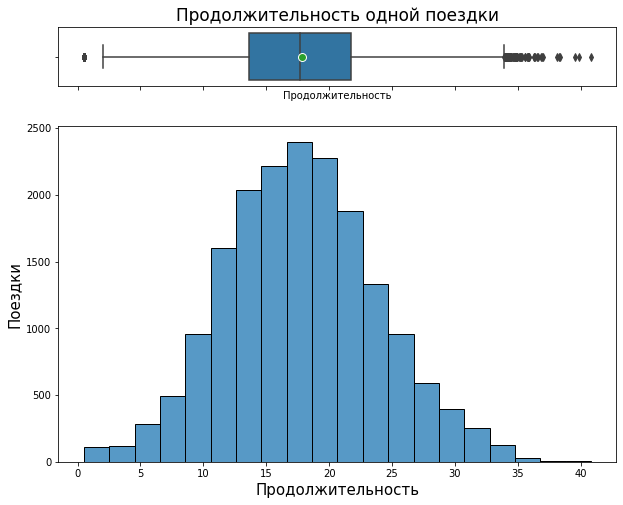

Статистические данные по времени одной поездки: 

count   18,068.00
mean        17.81
std          6.09
min          0.50
25%         13.60
50%         17.68
75%         21.72
max         40.82
Name: Продолжительность, dtype: float64


In [25]:
#Построим гистограмму и боксплот для длительности поездок
# создадим два подграфика
f, (ax_box, ax_hist) = \
plt.subplots(nrows = 2, 
             ncols = 1, 
             sharex = True, 
             gridspec_kw = {'height_ratios': (.15, .85)},
             figsize = (10,8)) 
# в первом подграфике построим boxplot
sns.boxplot(x = rides['Продолжительность'],
            ax = ax_box,
            showmeans=True, # покажем среднее значение
            meanprops={"marker": "o",
                       "markeredgecolor": "white",
                       "markersize": "8"})
# во втором гистограмму
sns.histplot(data = rides['Продолжительность'], bins = 20, ax = ax_hist)

# зададим заголовок и подписи к осям
ax_box.set_title('Продолжительность одной поездки', fontsize = 17)
ax_hist.set_xlabel('Продолжительность', fontsize = 15)
ax_hist.set_ylabel('Поездки', fontsize = 15)

plt.show()

#Покажем статистические данные
print('Статистические данные по времени одной поездки:', '\n')
print(rides['Продолжительность'].describe())

In [26]:
# Посмотрим какое количество поездок оказалось за верхней границей
q1 = rides['Продолжительность'].quantile(0.25)
q3 = rides['Продолжительность'].quantile(0.75)
iqr = q3-q1

print('Общее количество поездок:', rides['Продолжительность'].count())
print('Количество поездок за верхней границей:',
      rides.query('Продолжительность > @q3+@iqr*1.5')['Продолжительность'].count())

Общее количество поездок: 18068
Количество поездок за верхней границей: 82


Средняя продолжительность поездки составляет 17,81 минут, что очень близко к медианному значению. Более половины всех пользователей укладывают свои поездки по времени в диапазон от 13 до 22 минут. Есть один выброс за пределами нижней границы усов, также несколько выбросов за верхним пределом, их менее 0,5% от общего количества.

**Вывод:**
По результатам исследовательского анализа можно сделать следующие выводы:

- Больше всего пользователей сервиса находятся в г.Пятигорске, их в данном датасете 218 человек. Меньше всего представлена Москва, здесь данные только о 168 пользователях. Всего в данной базе есть информация по восьми городам.
- Пользователей с подпиской на 8,8% иеньше, чем пользователей без подписки.
- Средний возраст пользователя - 25 лет. В возрастную группу от 22 до 28 лет входит 50% всех клиентов. 
- Расстоянние, которое в среднем проезжают пользователи за одну поездку, равняется 3070 метрам. Это значение близко к медиане, которая равна 3133 метра. Основная часть всех поездок укладывается в диапазон расстояний от 2,5 до 3,8 км. - Средняя продолжительность поездки составляет 17,81 минут. Более половины всех пользователей укладывают свои поездки по времени в диапазон от 13 до 22 минут. 

#### Шаг 4. Объединение данных

##### Объединяем данные о пользователях, поездках и подписках в один датафрейм.

In [27]:
temp = users.copy() # создаем копию датасета до преобразования

len(temp)# посмотрим размер датасета до преобразования

1534

In [28]:
len(rides)# посмотрим размер датасета до преобразования

18068

In [29]:
len(subscriptions)# посмотрим размер датасета до преобразования

2

In [30]:
# Объединим сначала два датасета по столбцу с ID пользователя
users = users.merge(rides, on='Пользователи', how='outer')

# Затем объединим получившийся датасет с третьим по столбцу Подписка
users = users.merge(subscriptions, on='Подписка', how='outer')

users.head()

,Пользователи,Имя,Возраст,Город,Подписка,Расстояние,Продолжительность,Дата,Месяц,Стоимость минуты,Стоимость старта,Ежемесячный платеж
0,1,Кира,22,Тюмень,ultra,"4,409.92",25.60,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,"2,617.59",15.82,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.23,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,"2,694.78",18.51,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,"4,028.69",26.27,2021-08-28,8,6,0,199


In [31]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Пользователи        18068 non-null  int64         
 1   Имя                 18068 non-null  object        
 2   Возраст             18068 non-null  int64         
 3   Город               18068 non-null  object        
 4   Подписка            18068 non-null  object        
 5   Расстояние          18068 non-null  float64       
 6   Продолжительность   18068 non-null  float64       
 7   Дата                18068 non-null  datetime64[ns]
 8   Месяц               18068 non-null  int64         
 9   Стоимость минуты    18068 non-null  int64         
 10  Стоимость старта    18068 non-null  int64         
 11  Ежемесячный платеж  18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [32]:
len(users)# посмотрим размер датасета после объединения

18068

##### Создаем ещё два датафрейма из датафрейма, созданного на этапе 4.1.

In [33]:
# Создаем датафрейм с данными о пользователях без подписки
users_free = users[users['Подписка'] == 'free']

In [34]:
users_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Пользователи        11568 non-null  int64         
 1   Имя                 11568 non-null  object        
 2   Возраст             11568 non-null  int64         
 3   Город               11568 non-null  object        
 4   Подписка            11568 non-null  object        
 5   Расстояние          11568 non-null  float64       
 6   Продолжительность   11568 non-null  float64       
 7   Дата                11568 non-null  datetime64[ns]
 8   Месяц               11568 non-null  int64         
 9   Стоимость минуты    11568 non-null  int64         
 10  Стоимость старта    11568 non-null  int64         
 11  Ежемесячный платеж  11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


In [35]:
# Создаем датафрейм с данными о пользователях с подпиской
users_ultra = users[users['Подписка'] == 'ultra']

In [36]:
users_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Пользователи        6500 non-null   int64         
 1   Имя                 6500 non-null   object        
 2   Возраст             6500 non-null   int64         
 3   Город               6500 non-null   object        
 4   Подписка            6500 non-null   object        
 5   Расстояние          6500 non-null   float64       
 6   Продолжительность   6500 non-null   float64       
 7   Дата                6500 non-null   datetime64[ns]
 8   Месяц               6500 non-null   int64         
 9   Стоимость минуты    6500 non-null   int64         
 10  Стоимость старта    6500 non-null   int64         
 11  Ежемесячный платеж  6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


##### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

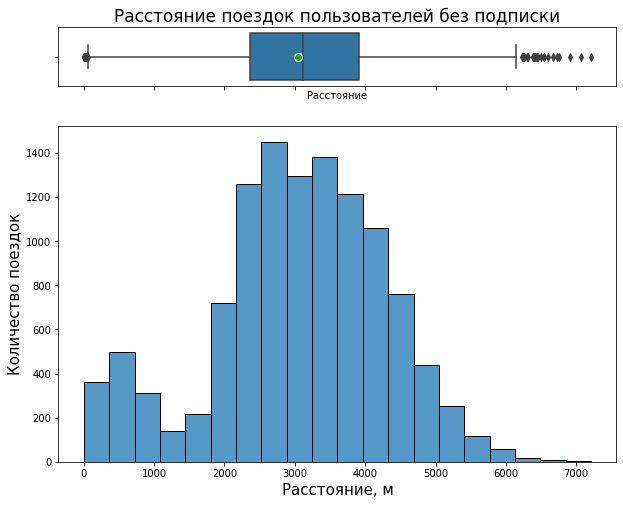

Статистические данные по расстоянию поездок пользователей без подписки: 

count   11,568.00
mean     3,045.50
std      1,246.17
min          0.86
25%      2,366.56
50%      3,114.65
75%      3,905.70
max      7,211.01
Name: Расстояние, dtype: float64


In [37]:
#Построим гистограмму и боксплот для расстояния поездок
#пользователей  без подписки
# создадим два подграфика
f, (ax_box, ax_hist) = \
plt.subplots(nrows = 2, # из двух строк
             ncols = 1, # и одного столбца
             sharex = True, # оставим только нижние подписи к оси Х
             gridspec_kw = {'height_ratios': (.15, .85)}, # зададим разную высоту строк
             figsize = (10,8)) # зададим размер графика
# в первом подграфике построим boxplot
sns.boxplot(x = users_free['Расстояние'],
            ax = ax_box,
            showmeans=True, # покажем среднее значение
            meanprops={"marker": "o",
                       "markeredgecolor": "white",
                       "markersize": "8"})
# во втором гистограмму
sns.histplot(data = users_free['Расстояние'], bins = 20, ax = ax_hist)
 
# зададим заголовок и подписи к осям
ax_box.set_title('Расстояние поездок пользователей без подписки', fontsize = 17)
ax_hist.set_xlabel('Расстояние, м', fontsize = 15)
ax_hist.set_ylabel('Количество поездок', fontsize = 15)

plt.show()

#Покажем статистические данные
print('Статистические данные по расстоянию поездок пользователей без подписки:', '\n')
print(users_free['Расстояние'].describe())

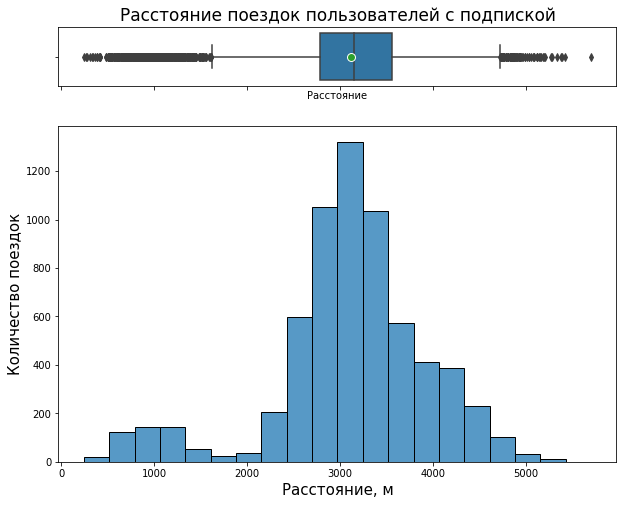

Статистические данные по расстоянию поездок пользователей с подпиской: 

count   6,500.00
mean    3,115.45
std       836.90
min       244.21
25%     2,785.44
50%     3,148.64
75%     3,560.57
max     5,699.77
Name: Расстояние, dtype: float64


In [38]:
#Построим гистограмму и боксплот для расстояния поездок
#пользователей  с подпиской
# создадим два подграфика
f, (ax_box, ax_hist) = plt.subplots(nrows = 2, 
                                    ncols = 1, 
                                    sharex = True, 
                                    gridspec_kw = {'height_ratios': (.15, .85)}, 
                                    figsize = (10,8)) 
# в первом подграфике построим boxplot
sns.boxplot(x = users_ultra['Расстояние'],
            ax = ax_box,
            showmeans=True,
            meanprops={"marker": "o",
                       "markeredgecolor": "white",
                       "markersize": "8"})
# во втором гистограмму
sns.histplot(data = users_ultra['Расстояние'], bins = 20, ax = ax_hist)
 
# зададим заголовок и подписи к осям
ax_box.set_title('Расстояние поездок пользователей с подпиской', fontsize = 17)
ax_hist.set_xlabel('Расстояние, м', fontsize = 15)
ax_hist.set_ylabel('Количество поездок', fontsize = 15)

plt.show()

#Покажем статистические данные
print('Статистические данные по расстоянию поездок пользователей с подпиской:', '\n')
print(users_ultra['Расстояние'].describe())

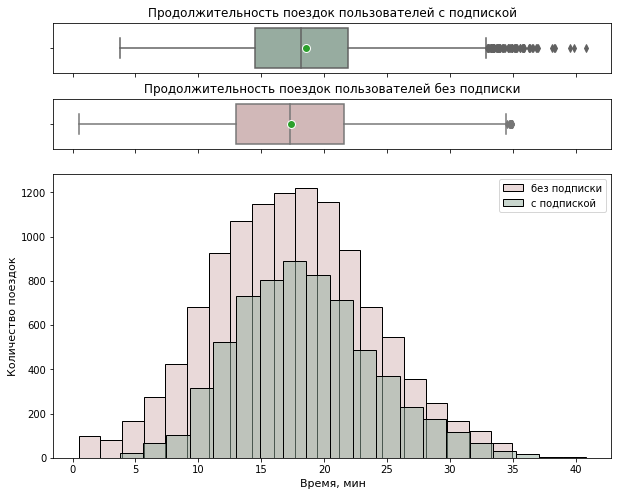

Статистические данные по длительности поездок пользователей с подпиской 

count   6,500.00
mean       18.54
std         5.57
min         3.76
25%        14.52
50%        18.18
75%        21.88
max        40.82
Name: Продолжительность, dtype: float64


In [69]:
#Построим гистограмму и боксплот для длительности поездок
#пользователей  с подпиской и без
# создадим два подграфика
f, (ax_box, ax_box_2, ax_hist) = plt.subplots(nrows = 3, 
                                    ncols = 1, 
                                    sharex = True, 
                                    gridspec_kw = {'height_ratios': (.15, .15, .85)}, 
                                    figsize = (10,8)) 
# в первом подграфике построим boxplot
sns.boxplot(x = users_ultra['Продолжительность'],
            ax = ax_box,
            showmeans=True,
            meanprops={"marker": "o",
                       "markeredgecolor": "white",
                       "markersize": "8"},
            color='#94AF9F')

sns.boxplot(x = users_free['Продолжительность'],
            ax = ax_box_2,
            showmeans=True,
            meanprops={"marker": "o",
                       "markeredgecolor": "white",
                       "markersize": "8"},
            color='#D5B4B4')

# во втором гистограмму
sns.histplot(data = users_free['Продолжительность'], bins = 20, ax = ax_hist, color='#D5B4B4', alpha=.5, label='без подписки')
sns.histplot(data = users_ultra['Продолжительность'], bins = 20, ax = ax_hist, color='#94AF9F', alpha=.5, label='с подпиской')
ax_hist.legend()
 
# зададим заголовок и подписи к осям
ax_box.set_title('Продолжительность поездок пользователей с подпиской', fontsize = 12)
ax_box.set_xlabel('')
ax_box_2.set_title('Продолжительность поездок пользователей без подписки', fontsize = 12)
ax_box_2.set_xlabel('')
ax_hist.set_xlabel('Время, мин', fontsize = 11)
ax_hist.set_ylabel('Количество поездок', fontsize = 11)

plt.show()

print('Статистические данные по длительности поездок пользователей с подпиской', '\n')
print(users_ultra['Продолжительность'].describe())

**Вывод:**

  На данном этапе мы собрали все данные в один датафрейм, а затем сделали еще два отдельных датафрейма: для пользователей с подпиской и без подписки. В результате этого мы смогли визуализировать такие показатели как дальность и продолжительность поездок для каждой категории пользователей отдельно.
  
  Следует отметить, что в исследуемом датасете пользователей без подписки всего на 8,8% больше, чем с подпиской, однако, за представленный период первые совершили почти в два раза больше поездок, чем вторые. При этом, средние значения и медианы для обоих групп схожи и находятся в радиусе +/- 50м от отметки в 3100 м. По продолжительности поездок показатели для обоих групп тоже схожи. Разница между средними и медианными значениями в пределах 1 минуты. Для пользователей без подписки среднее время составляет 17,39 мин, для пользователей с подпиской - 18,54 мин.

#### Подсчёт выручки

 ##### Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4. Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [41]:
# Округлим значения продолжительности поездок до объединения
users['Продолжительность'] = np.ceil(users['Продолжительность'])

# Создадим датафрейм с использованием сводной таблицы
users_agg = users.pivot_table(
    index=['Пользователи', 'Месяц', 'Подписка'],
    values=['Расстояние', 'Продолжительность', 'Имя'],
    aggfunc={'Расстояние':'sum', 'Продолжительность':'sum', 'Имя':'count'})\
    .reset_index()

# Переименуем столбцы
users_agg = users_agg.rename(columns={'Имя':'Кол-во поездок'})

users_agg.head(10)

,Пользователи,Месяц,Подписка,Кол-во поездок,Продолжительность,Расстояние
0,1,1,ultra,2,42.00,"7,027.51"
1,1,4,ultra,1,7.00,754.16
2,1,8,ultra,2,46.00,"6,723.47"
3,1,10,ultra,2,32.00,"5,809.91"
4,1,11,ultra,3,56.00,"7,003.50"
5,1,12,ultra,2,28.00,"6,751.63"
6,2,3,ultra,3,63.00,"10,187.72"
7,2,4,ultra,2,40.00,"6,164.38"
8,2,6,ultra,1,14.00,"3,255.34"
9,2,7,ultra,2,48.00,"6,780.72"


 ##### Добавим столбец с помесячной выручкой, которую принёс каждый пользователь. 

In [42]:
# Сначал объединим новый датафрейм с датафреймом о подписках
users_agg = users_agg.merge(subscriptions, on='Подписка', how='outer')

# Теперь добавим нужный столбец
users_agg['Выручка'] = (users_agg['Стоимость старта'] *\
                        users_agg['Кол-во поездок'] +\
                        users_agg['Продолжительность'] *\
                        users_agg['Стоимость минуты'] +\
                        users_agg['Ежемесячный платеж'])

users_agg.head(10)

,Пользователи,Месяц,Подписка,Кол-во поездок,Продолжительность,Расстояние,Стоимость минуты,Стоимость старта,Ежемесячный платеж,Выручка
0,1,1,ultra,2,42.00,"7,027.51",6,0,199,451.00
1,1,4,ultra,1,7.00,754.16,6,0,199,241.00
2,1,8,ultra,2,46.00,"6,723.47",6,0,199,475.00
3,1,10,ultra,2,32.00,"5,809.91",6,0,199,391.00
4,1,11,ultra,3,56.00,"7,003.50",6,0,199,535.00
5,1,12,ultra,2,28.00,"6,751.63",6,0,199,367.00
6,2,3,ultra,3,63.00,"10,187.72",6,0,199,577.00
7,2,4,ultra,2,40.00,"6,164.38",6,0,199,439.00
8,2,6,ultra,1,14.00,"3,255.34",6,0,199,283.00
9,2,7,ultra,2,48.00,"6,780.72",6,0,199,487.00


 **Вывод:**

Для создания датафрейма с агрегированными данными о поездках мы использовали сводные таблицы и применили разные функции к отдельным столбцам.
Для подсчета выручки, которую принес каждый пользователь, мы объединили созданный датафрейм с датафреймом о подписках, затем добавили в него столбец с расчетом выручки.

#### Проверка гипотез

##### Гипотеза 1: Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки

Для проверки данной гипотезы будем использовать исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

- Н0 - продолжительность сессии у пользователей с подпиской такая же, как и у пользователей без подписки
- Н1 - продолжительность сессии у пользователей с подпиской больше,  чем у пользователей без подписки

In [43]:
# Задаем уровень статистической значимости
alpha = 0.05 

# Применим ttest для сравнения средних двух генеральных совокупностей
results_g1 = st.ttest_ind(
    users_ultra['Продолжительность'], 
    users_free['Продолжительность'],
    equal_var=False, # совокупности разные по размеру и дисперсии могут быть разные
    alternative='greater')

print('Средняя продолжительность поездок пользователей с подпиской:',
      users_ultra['Продолжительность'].mean().round(2))
print('Средняя продолжительность поездок пользователей без подписки:',
      users_free['Продолжительность'].mean().round(2))
print('p-значение:', results_g1.pvalue)

if results_g1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средняя продолжительность поездок пользователей с подпиской: 18.54
Средняя продолжительность поездок пользователей без подписки: 17.39
p-значение: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


**Вывод:**
Гипотеза о том, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки - **подтверждается**.

##### Гипотеза 2: Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

Для проверки данной гипотезы будем использовать исходные данные о расстоянии каждой поездки пользователей с подпиской.

- Н0 - расстояние, которое проезжают пользователи с подпиской за одну поездку равно 3130 метров
- Н1 - расстояние, которое проезжают пользователи с подпиской за одну поездку больше 3130 метров

In [44]:
# Оптимальное расстояние одной поездки
distance = 3130 

alpha = 0.05 # уровень статистической значимости

# Применим ttest правосторонний
results_g2 = st.ttest_1samp(
    users_ultra['Расстояние'], 
    distance,
    alternative='greater')

print('p-значение:', results_g2.pvalue)

if results_g2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**Вывод:**
Гипотеза о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130 метров - **подтверждается**.

##### Гипотеза 3: Среднемесячная выручка от пользователей с подпиской по выше, чем  от пользователей без подписки. 

Для проверки данной гипотезы будем сравнивать среднемесячные показатели выручки для подписчиков и для тех, у кого нет подписки.

- Н0 - среднемесячная выручка у пользователей с подпиской такая же, как и у пользователей без подписки
- Н1 - среднемесячная выручка у пользователей с подпиской больше,  чем у пользователей без подписки

In [45]:
users_agg_ultra = users_agg[users_agg['Подписка'] == 'ultra']
users_agg_free = users_agg[users_agg['Подписка'] == 'free']

# Задаем уровень статистической значимости
alpha = 0.05 

# Применим ttest для сравнения средних двух генеральных совокупностей
results_g3 = st.ttest_ind(
    users_agg_ultra['Выручка'], 
    users_agg_free['Выручка'],
    equal_var=False, # совокупности разные по размеру и дисперсии могут быть разные
    alternative='greater')

print('Среднемесячная выручка пользователей с подпиской:',
      users_agg_ultra['Выручка'].mean().round(2))
print('Среднемесячна выручка пользователей без подписки:',
      users_agg_free['Выручка'].mean().round(2))
print('p-значение:', results_g3.pvalue)

if results_g3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднемесячная выручка пользователей с подпиской: 362.79
Среднемесячна выручка пользователей без подписки: 328.64
p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


**Вывод:**
Гипотеза о том, что среднемесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки - **подтверждается**.

##### Теоретический вопрос.

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ:**
Выборки в этом случае будут зависимыми, т.к. некоторая переменная (в нашем случае это количество обращений в службу поддержки) измеряется дважды для одних и тех же объектов. Поэтому, чтобы проверить гипотезу о равенстве средних двух генеральных совокупностей для зависимых выборок, мы применим метод **scipy.stats.ttest_rel()**. Ему передадим два параметра: наборы данных о количестве обращений до обновления и после него.

**Вывод:**
В ходе проверки подтвердились следующие гипотезы:
- пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки
- расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130 метров
- среднемесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки

Из этого можно сделать вывод, что увеличение числа пользователей с подпиской может помочь бизнесу вырасти. Поэтому проведение различных акций, способствующих этому, выглядит оправданным действием

#### Распределения

##### Задача 1.
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 
100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

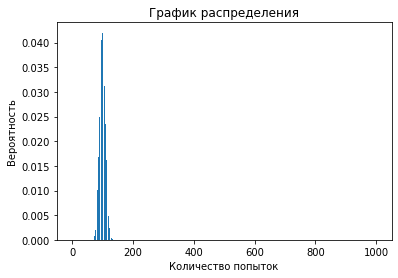

In [46]:
n = 1000 # количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr.append(prob)
    
plt.bar(range(0, n + 1), distr)
plt.title('График распределения')
plt.xlabel('Количество попыток')
plt.ylabel('Вероятность');

In [47]:
# количество попыток
n = 1170
# вероятность успеха
p = 0.1
# математическое ожидание
mu = n * p
# стандартное отклонение
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение 
distr = st.norm(mu, sigma) 

# считаем вероятность получить значение, равное 100 или меньше 
result = distr.cdf(100).round(2)

print(result)

0.05


**Вывод:**
Мы имеем дело с биноминальным распределением. Из построенного графика видно, что при количестве попыток (выданных промокодах) равном 1000 и вероятности 0.1 (10%) вероятность получить 100 подписок  около 50%. Для того, чтобы эту вероятность увеличить, нужно выдать больше промокодов. Для нашей задачи нужно найти такое количество выданных промокодов, чтобы вероятность получить 100 подписчиков была не ниже 95%. С помощью метода **cdf** мы определили, что нам необходимо выдать не менее **1170** промокодов, тогда мы добьемся нужного результата.

##### Задача 2.
 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

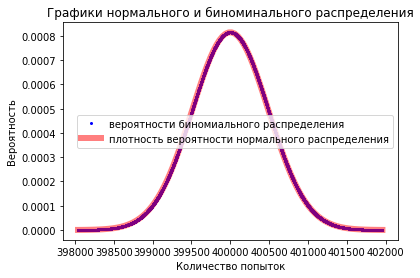

Условие апроксимации выполняется


In [48]:
# Выясним,  выполняется ли условие апроксимации

# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 2
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=2,
      label='вероятности биномиального распределения')

# зададим параметры нормального распределения равными
# мат.ожиданию и отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 6 и прозрачности 0.5
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=6, alpha=0.5,
        label='плотность вероятности нормального распределения')
 
# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.title('Графики нормального и биноминального распределения')
plt.xlabel('Количество попыток')
plt.ylabel('Вероятность')
plt.show()

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие апроксимации выполняется')
else:
    print('Условие апроксимации не выполняется')

In [49]:
# Апроксимируем биноминальное распределение нормальным и рассчитаем вероятность

# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# мат.ожидание и стандартное отклонение
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399,5 тысяч
result = distr.cdf(399500)
print(result)

0.15371708296369768


**Вывод:**

В данной задаче мы сначала проверили условию апроксимации (лежит ли промежуток (mu +- 3sigma) в пределах, где биноминальное распределение определено. На графике видно, что его форма симметрична  имеет нормальное распределение. Затем, апроксимировали биноминальное распределение нормальным и на шли вероятность выполнения нашего условия. Ответ задачи: при рассылке 1 млн. уведомлений, вероятность что их откроют не более 399,5 тыс. пользователей равна 15,4%

#### Общий вывод

В ходе проекта по исследованию данных сервиса аренды самокатов установлено следующее:

- Данные, предоставленные для анализа, содержат сведения о  чуть более 1500 пользователях сервиса аренды и более 18 тыс. совершенных этими пользователями поездках. Пропусков в данных обнаружено не было. Но нашлось несколько явных дубликатов, которые были удалены.
- Больше всего пользователей сервиса находятся в г.Пятигорске, их в данном датасете 218 человек. Меньше всего представлена Москва, здесь данные только о 168 пользователях. Всего в данной базе есть информация по восьми городам.
- Пользователей с подпиской на 8,8% иеньше, чем пользователей без подписки.
- Средний возраст пользователя - 25 лет. В возрастную группу от 22 до 28 лет входит 50% всех клиентов. 
- Расстоянние, которое в среднем проезжают пользователи за одну поездку, равняется 3070 метрам. Это значение близко к медиане, которая равна 3133 метра. Основная часть всех поездок укладывается в диапазон расстояний от 2,5 до 3,8 км. - Средняя продолжительность поездки составляет 17,81 минут. Более половины всех пользователей укладывают свои поездки по времени в диапазон от 13 до 22 минут.
- В ходе исследования мы сделали два отдельных датафрейма: для пользователей с подпиской и без подписки. В результате этого мы смогли визуализировать такие показатели как дальность и продолжительность поездок для каждой категории пользователей отдельно. Также мы подсчитали выручку, которую принесли пользователи двух категорий.
- Заметим, что за представленный период пользователи без подписки совершили почти в два раза больше поездок, чем пользователи с подпиской. При этом, средние значения и медианы для обоих групп схожи и находятся в радиусе +/- 50м от отметки в 3100 м. По продолжительности поездок показатели для обоих групп тоже схожи. Разница между средними и медианными значениями в пределах 1 минуты. Для пользователей без подписки среднее время составляет 17,39 мин, для пользователей с подпиской - 18,54 мин.
- При схожести средних показателей, разница все же существует. На основании этого были выдвинуты и проверены несколько гипотез. По их результатам установлено, что:
  - пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки
  - расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130 метров
  - среднемесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки

**Из этого можно сделать вывод, что увеличение числа пользователей с подпиской может помочь бизнесу вырасти. Поэтому проведение различных акций, способствующих этому, выглядит оправданным действием**